In [1]:
import os
from codecarbon import track_emissions
import numpy as np


def load_data_by_dimension(dimension, dataset_path=""):
    root = os.path.join(dataset_path, "./datasets/")
    data_filename = root + f'kryptonite-{dimension}-X.npy'
    labels_filename = root + f'kryptonite-{dimension}-y.npy'
    data = np.load(data_filename)
    labels = np.load(labels_filename)
    print(f"Loaded dataset with dimension {dimension}. Data shape: {data.shape}, Labels shape: {labels.shape}")
    return data, labels

In [ ]:
import time
from datetime import datetime
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cs = {
    "layer_width": tune.choice([4, 8, 16, 24, 32]),
    "layer_depth": tune.randint(2, 4),
    "activation": tune.choice(['relu', 'tanh']),
    "lr": tune.loguniform(1e-4, 1e-2),
    "momentum": tune.uniform(0.1, 0.9),
    "portion": tune.choice([3, 4, 5])
}


# the function used in search
def objective(config):
    data, labels = load_data_by_dimension(objective.dim, objective.dataset_path)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    # Scale the data
    sc = StandardScaler()
    scaler = sc.fit(X_train)
    trainX_scaled = scaler.transform(X_train)
    testX_scaled = scaler.transform(X_test)
    # Build the model
    layers = [config["layer_width"]] * config["layer_depth"]
    print(f"Training with layers: {layers} and activation function: {config["activation"]}")
    model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=config["activation"],
                          learning_rate_init=config["lr"], momentum=config["momentum"])
    # Report the accuracy result
    while True:
        model.fit(trainX_scaled, y_train)
        acc = model.score(testX_scaled, y_test)
        train.report({"mean_accuracy": acc})  # Report to Tune

In [ ]:
# Hyperparameter search
def search(dim):
    algo = OptunaSearch()
    # Set function attributes
    objective.dim = dim
    objective.dataset_path = os.getcwd()
    # Configure the tuner
    tuner = tune.Tuner(
        objective,
        tune_config=tune.TuneConfig(
            metric="mean_accuracy",
            mode="max",
            search_alg=algo,
            num_samples=-1,
            time_budget_s=60 * 10,
            trial_dirname_creator=lambda x: datetime.now().strftime("%H_%M_%S")
        ),
        run_config=train.RunConfig(
            storage_path=os.path.join(os.getcwd(), "./results"),  # store trail runs' details
            name="simpleneuralnetwork",
            verbose=0,
        ),
        param_space=cs,
    )
    # Run the tuner
    begin = time.time()
    results = tuner.fit()
    end = time.time() - begin
    # Get the best result
    best_result = results.get_best_result(metric="mean_accuracy", mode="max")
    best_config = best_result.config
    # Print the results
    print("auto optimization finished")
    print('time for optimisation (seconds):' + str(end))
    print("Best trial config: {}".format(best_config))
    print("Best accuracy: {}".format(best_result.metrics["mean_accuracy"]))
    return best_config

In [ ]:
import matplotlib.pyplot as plt
import json

# Pre-defined dimensions in use
dimensions = [9, 12, 15, 18, 24, 30, 45]
accuracies = []

# Search for the best configuration for each dimension
for dim in dimensions:
    # Search for the best configuration
    best = search(dim)
    # Save the configuration
    with open(f"./results/best_config_dim{dim}.json", "w") as f:
        json.dump(best, f)
    # Load the data
    data, labels = load_data_by_dimension(dim)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    # Scale the data
    sc = StandardScaler()
    scaler = sc.fit(X_train)
    trainX_scaled = scaler.transform(X_train)
    testX_scaled = scaler.transform(X_test)
    # Build the model
    layers = [best["layer_width"]] * best["layer_depth"]
    model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=best["activation"],
                          learning_rate_init=best["lr"], momentum=best["momentum"])
    # Run the model and record the accuracy
    model.fit(trainX_scaled, y_train)
    accuracy = model.score(testX_scaled, y_test)
    accuracies.append(accuracy)

# Plot the performance of models with their best k
plt.figure(figsize=(10, 5))
plt.plot(dimensions, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Performance vs. Dimensionality')
plt.grid(True)
plt.show()

In [ ]:
# Get mean and standard deviation of the best configurations
means = []
std_devs = []
# Loop for each dimension
for dim in dimensions:
    # Load the best configuration
    with open(f"./results/best_config_dim{dim}.json", "r") as f:
        best = json.load(f)
    # Load the data
    data, labels = load_data_by_dimension(dim)
    accuracies = []
    # Run the model 10 times with difference train-test splits
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
        sc = StandardScaler()
        scaler = sc.fit(X_train)
        trainX_scaled = scaler.transform(X_train)
        testX_scaled = scaler.transform(X_test)
        layers = [best["layer_width"]] * best["layer_depth"]
        model = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, activation=best["activation"],
                              learning_rate_init=best["lr"], momentum=best["momentum"])
        model.fit(trainX_scaled, y_train)
        accuracy = model.score(testX_scaled, y_test)
        accuracies.append(accuracy)
    # Record the mean and standard deviation of the run
    accuracies = np.array(accuracies)
    means.append(np.mean(accuracies))
    std_devs.append(np.std(accuracies))

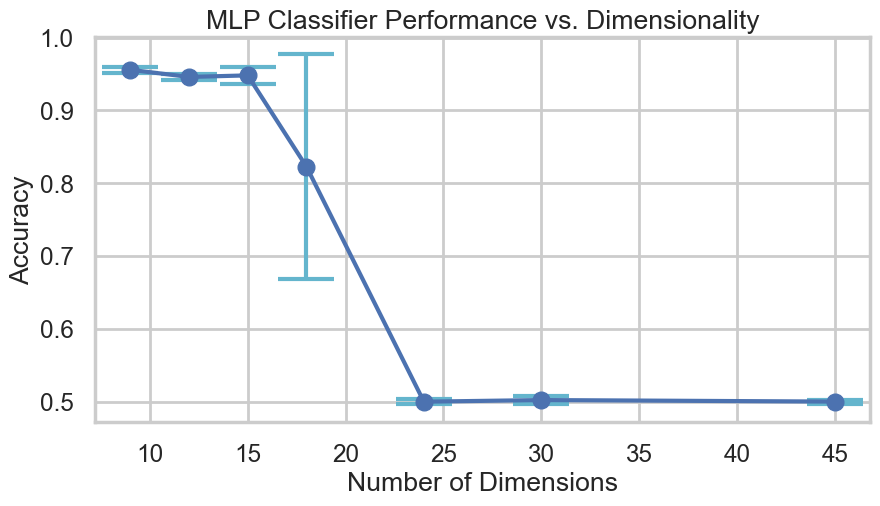

In [ ]:
# Plot the performance of models and show the standard deviation
plt.figure(figsize=(10, 5))
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Performance vs. Dimensionality')
plt.grid(True)
plt.show()

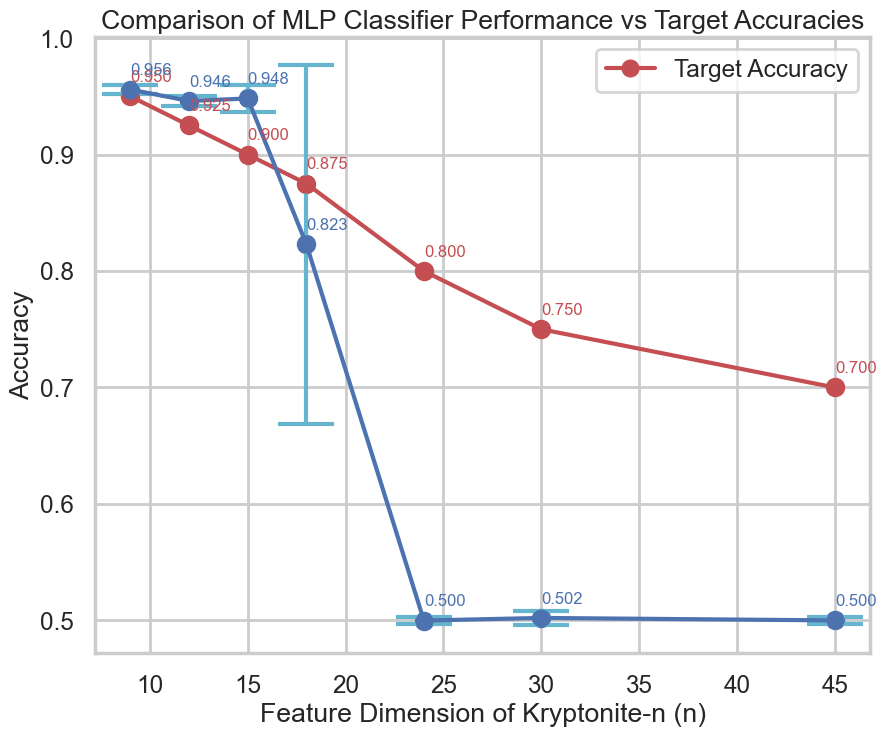

In [ ]:
import seaborn as sns

# Plot the performance of models, compare with target accuracies
n = [9, 12, 15, 18, 24, 30, 45]
target_accuracies = [0.95, 0.925, 0.9, 0.875, 0.8, 0.75, 0.7]

# Plotting settings
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8)
plt.figure(figsize=(10, 8))

# Plotting MLPC performance
plt.errorbar(dimensions, means, yerr=std_devs, marker='o', linestyle='-', color='b', ecolor='c', capsize=20, capthick=3)
plt.scatter(dimensions, means, color='b')

# Plotting target accuracies
plt.plot(n, target_accuracies, label='Target Accuracy', marker='o', linestyle='-', color='r')
plt.scatter(n, target_accuracies, color='r')

# Annotating target accuracies
ax = plt.gca()
for j, (x, y) in enumerate(zip(n, target_accuracies)):
    ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='r', size=12)
for j, (x, y) in enumerate(zip(n, means)):
    ax.text(x, y + 0.01, f'{y:.3f}', ha='left', va='bottom', color='b', size=12)

# Titles and labels
plt.title("Comparison of MLP Classifier Performance vs Target Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Feature Dimension of Kryptonite-n (n)")
plt.legend()

# Show the plot
plt.show()